### Tarea 6. División del conjunto de datos Tileado

### Se crean las carpetas destino para cada subconjunto.
# La estructura sigue el estándar de YOLO: images/train, labels/train, etc.


In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [10]:
# ------------------------------
#  CARGAR IMAGEN
# ------------------------------
IMG_PATH = r"C:\Users\GARI\Documents\PROYECTO\1_1.jpg"   # tu imagen pública
img = cv2.imread(IMG_PATH)
if img is None:
    raise FileNotFoundError(f"No se pudo leer la imagen: {IMG_PATH}")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]

print("Resolución:", W, "x", H)

Resolución: 1248 x 908


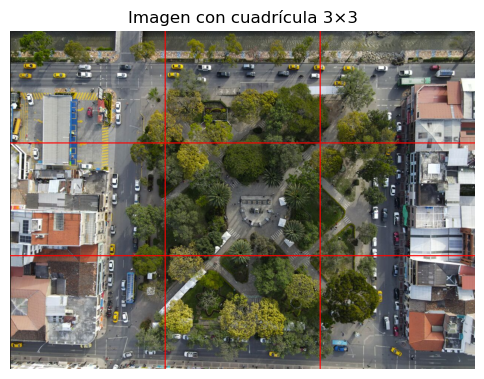

In [13]:
# ------------------------------
# 2) DIBUJAR CUADRÍCULA 3×3
# ------------------------------
ROWS, COLS = 3, 3
cell_w = W // COLS
cell_h = H // ROWS

grid_img = img_rgb.copy()

# Líneas verticales
for c in range(1, COLS):
    x = c * cell_w
    cv2.line(grid_img, (x, 0), (x, H), (255, 0, 0), 2)

# Líneas horizontales
for r in range(1, ROWS):
    y = r * cell_h
    cv2.line(grid_img, (0, y), (W, y), (255, 0, 0), 2)

plt.figure(figsize=(6,6))
plt.imshow(grid_img)
plt.title("Imagen con cuadrícula 3×3")
plt.axis("off")
plt.show()


In [14]:
# ------------------------------
# 3) GENERAR LAS 9 SUBIMÁGENES
# ------------------------------
tiles = []
for r in range(ROWS):
    for c in range(COLS):
        x0 = c * cell_w
        y0 = r * cell_h
        # El último tile llega hasta el borde de la imagen
        x1 = (c + 1) * cell_w if c < COLS - 1 else W
        y1 = (r + 1) * cell_h if r < ROWS - 1 else H

        tile = img_rgb[y0:y1, x0:x1]
        tiles.append(tile)

print("Tiles generados:", len(tiles))  # debería ser 9

Tiles generados: 9


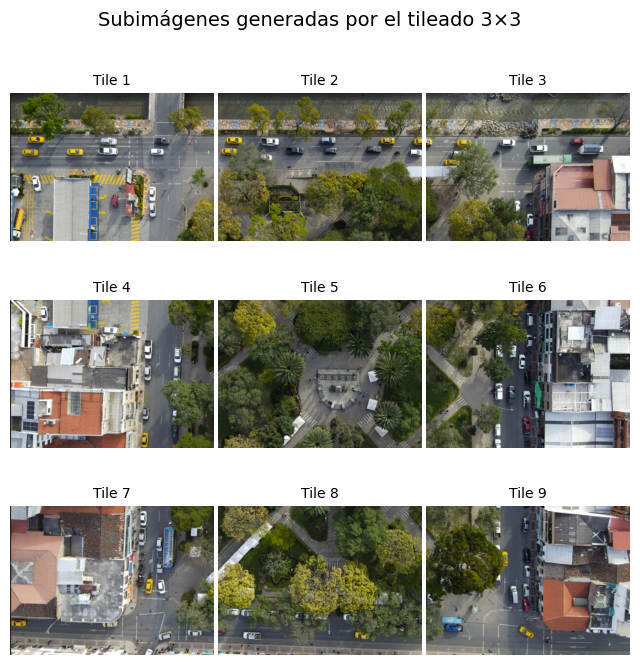

In [19]:
# ------------------------------
# MOSTRAR EN CUADRÍCULA COMPACTA
# ------------------------------
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

idx = 0
for r in range(3):
    for c in range(3):
        axes[r, c].imshow(tiles[idx])
        axes[r, c].set_title(f"Tile {idx+1}", fontsize=10)
        axes[r, c].axis("off")
        idx += 1

plt.subplots_adjust(
    wspace=0.02,   # espacio horizontal mínimo
    hspace=0.02    # espacio vertical mínimo
)

plt.suptitle("Subimágenes generadas por el tileado 3×3", y=0.95, fontsize=14)
plt.show()

### codigo que se usa para redimensionar las imagenes y no perder el etiquetado de las imagenes.

In [ ]:
!pip install -q opencv-python numpy

In [ ]:
import os, math, glob, random, shutil
import cv2
import numpy as np

In [ ]:
from pathlib import Path

# Carpeta de ENTRADA: una sola carpeta con imágenes (.jpg/.png) y sus .txt YOLO
INPUT_DIR = r'C:\Users\GARI\Documents\DATASETS\arboles_data_v1'

# Carpeta de SALIDA (se creará)
OUT_ROOT  = r"C:\Users\GARI\Desktop\DATA\DATASETS\dataset_1024_resolucion"    

# Parámetros de tileo
TILE         = 1024       # tamaño del tile (coincide con imgsz=640)
OVERLAP      = 0.20      # 20% solape (stride = 640*(1-0.2)=512)
MIN_VIS_FRAC = 0.50      # porcentaje mínimo del bbox visible para conservarlo
MIN_SIDE_PX  = 6         # descarta cajas demasiado pequeñas en el tile
SAVE_PNG     = True      # True = PNG (sin pérdida) | False = JPG calidad 95

# Split reproducible
SEED   = 42
SPLIT  = (0.8, 0.2, 0.1)  # train, val, test

In [ ]:
import os, math, glob, random, shutil
import cv2
import numpy as np

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def yolo_to_xyxy(parts, W, H):
    cls = int(parts[0]); xc=float(parts[1])*W; yc=float(parts[2])*H; w=float(parts[3])*W; h=float(parts[4])*H
    x1 = xc - w/2; y1 = yc - h/2; x2 = xc + w/2; y2 = yc + h/2
    return cls, x1, y1, x2, y2

def xyxy_to_yolo(cls, x1,y1,x2,y2, W,H):
    w = x2-x1; h = y2-y1
    xc = x1 + w/2; yc = y1 + h/2
    return f"{cls} {xc/W:.6f} {yc/H:.6f} {w/W:.6f} {h/H:.6f}"

def area(x1,y1,x2,y2): 
    return max(0, x2-x1) * max(0, y2-y1)

def intersect(a, b):
    x1=max(a[0],b[0]); y1=max(a[1],b[1]); x2=min(a[2],b[2]); y2=min(a[3],b[3])
    return (x1,y1,x2,y2)

def save_image(path, img, save_png=True):
    if save_png:
        # PNG: compresión ligera, sin pérdida
        cv2.imwrite(str(path.with_suffix(".png")), img, [cv2.IMWRITE_PNG_COMPRESSION, 3])
    else:
        # JPG alta calidad
        cv2.imwrite(str(path.with_suffix(".jpg")), img, [cv2.IMWRITE_JPEG_QUALITY, 95])

def ensure_dirs(root):
    (Path(root)/"all_tiles"/"images").mkdir(parents=True, exist_ok=True)
    (Path(root)/"all_tiles"/"labels").mkdir(parents=True, exist_ok=True)

def list_images(input_dir):
    p = Path(input_dir)
    return sorted([x for x in p.iterdir() if x.suffix.lower() in IMG_EXTS])

def tile_and_label(img_path, lbl_path, out_img_dir, out_lbl_dir,
                   tile=640, overlap=0.2, min_vis_frac=0.5, min_side_px=6, save_png=True):
    name = img_path.stem
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"[WARN] No pude leer {img_path}")
        return 0
    H, W = img.shape[:2]

    # Leer etiquetas YOLO si existen
    yolo_lines = []
    if Path(lbl_path).exists():
        with open(lbl_path, "r") as f:
            for line in f:
                s=line.strip()
                if not s: continue
                parts=s.split()
                if len(parts)==5:
                    yolo_lines.append(parts)

    abs_boxes=[]
    for parts in yolo_lines:
        cls,x1,y1,x2,y2 = yolo_to_xyxy(parts, W, H)
        abs_boxes.append((cls,x1,y1,x2,y2))

    stride = max(1, int(tile*(1-overlap)))
    nx = 1 + max(0, math.ceil((W - tile) / stride))
    ny = 1 + max(0, math.ceil((H - tile) / stride))

    saved = 0
    for iy in range(ny):
        for ix in range(nx):
            x0 = min(ix*stride, W - tile)
            y0 = min(iy*stride, H - tile)
            x1t, y1t = x0, y0
            x2t, y2t = x0 + tile, y0 + tile
            tile_box=(x1t,y1t,x2t,y2t)

            tile_img = img[y0:y0+tile, x0:x0+tile]
            out_base = f"{name}_{iy:02d}_{ix:02d}"

            new_labels=[]
            for cls,x1,y1,x2,y2 in abs_boxes:
                xi1,yi1,xi2,yi2 = intersect((x1,y1,x2,y2), tile_box)
                interA = area(xi1,yi1,xi2,yi2)
                if interA<=0: 
                    continue
                origA = area(x1,y1,x2,y2)
                vis = interA/(origA+1e-9)
                if vis < min_vis_frac:
                    continue
                # a coords del tile
                xi1 = max(0, xi1 - x0); yi1 = max(0, yi1 - y0)
                xi2 = min(tile, xi2 - x0); yi2 = min(tile, yi2 - y0)
                if (xi2 - xi1) < min_side_px or (yi2 - yi1) < min_side_px:
                    continue
                new_labels.append(xyxy_to_yolo(cls, xi1, yi1, xi2, yi2, tile, tile))

            # Guardar imagen y label
            img_out_path = Path(out_img_dir)/out_base
            save_image(img_out_path, tile_img, save_png=save_png)
            with open(Path(out_lbl_dir)/f"{out_base}.txt", "w") as f:
                for l in new_labels:
                    f.write(l+"\n")
            saved += 1
    return saved

def split_tiles(out_root, split=(0.7,0.2,0.1), seed=42):
    random.seed(seed)
    tmp_images = Path(out_root)/"all_tiles"/"images"
    tmp_labels = Path(out_root)/"all_tiles"/"labels"
    names = sorted([p.stem for p in tmp_images.iterdir() if p.is_file()])

    random.shuffle(names)
    n = len(names)
    n_train = int(n*split[0]); n_val = int(n*split[1])
    parts = {
        "train": names[:n_train],
        "val":   names[n_train:n_train+n_val],
        "test":  names[n_train+n_val:]
    }

    for sp, lst in parts.items():
        di = Path(out_root)/sp/"images"
        dl = Path(out_root)/sp/"labels"
        di.mkdir(parents=True, exist_ok=True)
        dl.mkdir(parents=True, exist_ok=True)
        for nb in lst:
            # imagen (png o jpg, el que exista)
            src_png = tmp_images/f"{nb}.png"
            src_jpg = tmp_images/f"{nb}.jpg"
            src_img = src_png if src_png.exists() else src_jpg
            shutil.copy2(src_img, di/src_img.name)
            shutil.copy2(tmp_labels/f"{nb}.txt", dl/f"{nb}.txt")
        print(f"[OK] {sp}: {len(lst)} tiles")

    # dataset.yaml
    yaml_path = Path(out_root)/"dataset.yaml"
    with open(yaml_path, "w") as f:
        f.write(f"path: {Path(out_root).resolve()}\n")
        f.write("train: train/images\nval: val/images\ntest: test/images\n")
        f.write("names:\n  0: arbol\n")
    print(f"[OK] dataset.yaml -> {yaml_path}")


In [ ]:
# crear carpetas temporales
ensure_dirs(OUT_ROOT)

# listar imágenes
imgs = list_images(INPUT_DIR)
print(f"[INFO] Imágenes encontradas: {len(imgs)}")

# tilear todas
out_img_dir = Path(OUT_ROOT)/"all_tiles"/"images"
out_lbl_dir = Path(OUT_ROOT)/"all_tiles"/"labels"

total_tiles = 0
for img_path in imgs:
    lbl_path = Path(INPUT_DIR)/f"{img_path.stem}.txt"
    saved = tile_and_label(
        img_path=img_path,
        lbl_path=lbl_path,
        out_img_dir=out_img_dir,
        out_lbl_dir=out_lbl_dir,
        tile=TILE, overlap=OVERLAP,
        min_vis_frac=MIN_VIS_FRAC,
        min_side_px=MIN_SIDE_PX,
        save_png=SAVE_PNG
    )
    total_tiles += saved

print(f"\n[OK] Tiles generados: {total_tiles}")

In [ ]:
import random

def draw_yolo_boxes(img, txt_path):
    H, W = img.shape[:2]
    if not Path(txt_path).exists(): 
        return img
    with open(txt_path, "r") as f:
        lines = [l.strip().split() for l in f if l.strip()]
    for c,xc,yc,w,h in lines:
        xc=float(xc)*W; yc=float(yc)*H; w=float(w)*W; h=float(h)*H
        x1=int(xc - w/2); y1=int(yc - h/2)
        x2=int(xc + w/2); y2=int(yc + h/2)
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
    return img

show_dir = Path(OUT_ROOT)/"train"/"images"
samples = random.sample(sorted(list(show_dir.iterdir()))[:200], k=min(9, len(list(show_dir.iterdir()))))
canvas = []
for s in samples:
    img = cv2.imread(str(s))
    drawn = draw_yolo_boxes(img.copy(), (s.parent.parent/"labels"/(s.stem + ".txt")))
    canvas.append(drawn)

# Mostrar en una cuadricula simple (si usas JupyterLab, esto imprime como matriz)
import numpy as np
grid = None
if canvas:
    rows = []
    for i in range(0, len(canvas), 3):
        row = np.hstack([im for im in canvas[i:i+3]])
        rows.append(row)
    grid = np.vstack(rows)
    # convertir BGR->RGB para mostrar
    from matplotlib import pyplot as plt
    plt.figure(figsize=(12,12))
    plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))
    plt.axis('off')